calculation of average power vs frequency bands for each day

In [1]:
import obspy
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.dates as dates
from scipy.signal import correlate
from scipy.stats.stats import pearsonr

In [2]:
in_dir = '../../data/banner/infrasound/out/'

In [3]:
# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()
dec = [i for i in r if i[2:4] == '12']
jan = [i for i in r if i[2:4] == '01']
pre_snow =[i for i in dec if int(i[-2:]) < 10]
post_snow =[i for i in dec if int(i[-2:]) > 12]
tonga = [i for i in jan if int(i[-2:]) > 14]
tonga = [i for i in tonga if int(i[-2:]) < 18]

In [4]:
## From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
sps = 200
x = np.arange(0,100,1)
f = 10/sps
y = np.sin(2*np.pi*x*f) + 0.5*np.random.rand(len(x))
y_filt = butter_bandpass_filter(y, 8, 12, sps, order= order)

plt.plot(x,y)
plt.plot(x,y_filt)

NameError: name 'order' is not defined

In [17]:
y = tr1.data
x = np.arange(0,len(y)-1, 1)

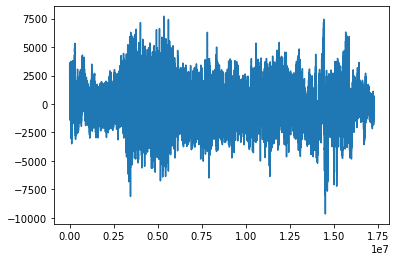

In [18]:
plt.plot(y)

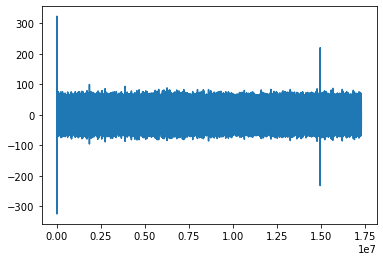

In [20]:
y_filt = butter_bandpass_filter(y, 20, 30, sps, order= order)
plt.plot(y_filt)

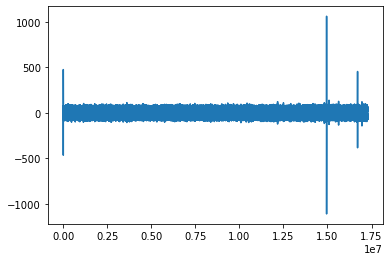

In [19]:
y_filt = butter_bandpass_filter(y, 5, 10, sps, order= order)
plt.plot(y_filt)

In [6]:
ac_calib = 8.2928e-05
order = 6
sps = 200
freq_range = [(5,10),(10,15),(15,20),(20,30)]
channels = ['p0','p1','p2']

days = tonga
channel_res = {}
for chan in channels:
    print(f'Working on {chan}')
    res = pd.DataFrame(index = days, columns = freq_range)
    for freqs in freq_range:
        print(freqs)
        for d in tqdm(days, unit = 'days'):
            st = obspy.Stream()
            for f in glob(os.path.join(in_dir, f'c0be4{d}*'), recursive= True):
                st += obspy.read(os.path.join(f))
                st.detrend("constant")
            st = st.merge(method = 1)
            tr1 = st.select(channel = chan)[0]
            sps = tr1.__dict__['stats']['sampling_rate'] #samples per second
            arr1 = tr1.data * ac_calib
            #arr1 = np.array(arr1, dtype=np.float64)
            arr1 = butter_bandpass_filter(arr1, freqs[0], freqs[1], sps, order= order)
            # plt.plot(arr1)
            # plt.show()
            ave_power = np.nanmean(np.square(arr1))
            res.loc[d, freq_range] = ave_power
    channel_res[chan] = res 


  0%|          | 0/3 [00:00<?, ?days/s]

Working on p0
(5, 10)


  0%|          | 0/3 [00:00<?, ?days/s]

(10, 15)


  0%|          | 0/3 [00:00<?, ?days/s]

(15, 20)


  0%|          | 0/3 [00:00<?, ?days/s]

(20, 30)


  0%|          | 0/3 [00:00<?, ?days/s]

Working on p1
(5, 10)


  0%|          | 0/3 [00:00<?, ?days/s]

(10, 15)


  0%|          | 0/3 [00:00<?, ?days/s]

(15, 20)


  0%|          | 0/3 [00:00<?, ?days/s]

(20, 30)


  0%|          | 0/3 [00:00<?, ?days/s]

Working on p2
(5, 10)


  0%|          | 0/3 [00:00<?, ?days/s]

(10, 15)


  0%|          | 0/3 [00:00<?, ?days/s]

(15, 20)


  0%|          | 0/3 [00:00<?, ?days/s]

(20, 30)


100%|██████████| 3/3 [00:02<00:00,  1.15days/s]


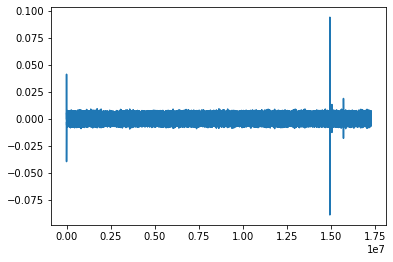

In [15]:
plt.plot(arr1)

In [7]:
channel_res['p0'][(10,15)]

220115    0.000003
220116    0.000003
220117    0.000003
Name: (10, 15), dtype: object

In [13]:
channel_res['p2'][(5,10)]

220115    0.000002
220116    0.000002
220117    0.000002
Name: (5, 10), dtype: object

In [15]:
channel_res['p2'][(20,30)]

220115    0.000002
220116    0.000002
220117    0.000002
Name: (20, 30), dtype: object

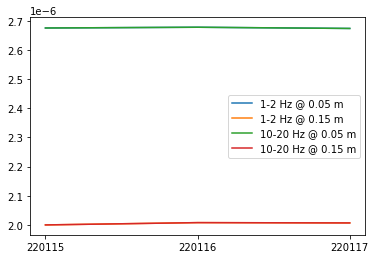

In [14]:
plt.plot(channel_res['p0'][(5,10)], label = '1-2 Hz @ 0.05 m')
plt.plot(channel_res['p2'][(5,10)], label = '1-2 Hz @ 0.15 m')
plt.plot(channel_res['p0'][(20,30)], label = '10-20 Hz @ 0.05 m')
plt.plot(channel_res['p2'][(20,30)], label = '10-20 Hz @ 0.15 m')
plt.legend()

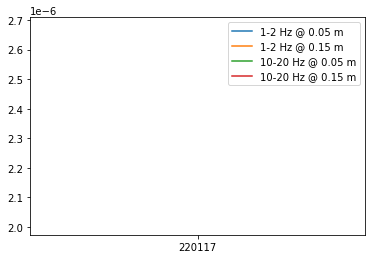

In [11]:
plt.plot(channel_res['p0'][(5,10)].rolling(3).median(), label = '1-2 Hz @ 0.05 m')
plt.plot(channel_res['p2'][(5,10)].rolling(3).median(), label = '1-2 Hz @ 0.15 m')
plt.plot(channel_res['p0'][(20,30)].rolling(3).median(), label = '10-20 Hz @ 0.05 m')
plt.plot(channel_res['p2'][(20,30)].rolling(3).median(), label = '10-20 Hz @ 0.15 m')
plt.legend()